# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, classification_report,precision_score, roc_auc_score,roc_curve, accuracy_score
import pylab as pl
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [36]:
df_raw = pd.read_csv("../assets/admissions.csv")

df = df_raw.dropna() 

#change datatype of prestige, to decimal in the dummy variable names
df.prestige = df.prestige.astype(int)

df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3
1,1,660.0,3.67,3
2,1,800.0,4.00,1
3,1,640.0,3.19,4
4,0,520.0,2.93,4


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
# frequency table for prestige and whether or not someone was admitted

dfcross = pd.crosstab(df.prestige,df.admit)
dfcross

admit,0,1
prestige,,
1,28,33
2,95,53
3,93,28
4,55,12


The frequency table reveals that less prestigious schools have a lower rate of acceptance. In order to get a clearer 
view of the percentages, the table below calculates the acceptance rates in terms of percentage. 

In [4]:
dfperc = dfcross.apply(lambda x: (x/sum(x))*100, axis = 1)
dfperc

admit,0,1
prestige,,
1,45.901639,54.098361
2,64.189189,35.810811
3,76.859504,23.140496
4,82.089552,17.910448


By showing the values in terms of percentage, it's evident that you have a better chance of getting admitted if you went to a school with a prestige rating of 1 or 2. But, it's also interesting that going to a great school doesn't necessarily guarantee admission. 45% of the students of the students that went to top schools did not get accepted into grad school. This implies that the GRE and GPA also influence the proability of acceptance. 

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [5]:
dummy_prestige = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_prestige.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We need n - 1 variables, n representing the number of categories. This is done to avoid colliearlity. 

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [6]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_prestige.ix[:, 'prestige_1':])
handCalc.head()

,admit,gre,gpa,prestige_1,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0.0,0.0,1.0,0.0
1,1,660.0,3.67,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,0.0,0.0,0.0
3,1,640.0,3.19,0.0,0.0,0.0,1.0
4,0,520.0,2.93,0.0,0.0,0.0,1.0


In [7]:
#crosstab prestige 1 admission 
#frequency table cutting prestige and whether or not someone was admitted
dfpres1 = pd.crosstab(handCalc['prestige_1'],handCalc.admit)
dfpres1

admit,0,1
prestige_1,,
0.0,243,93
1.0,28,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [8]:
one = (33./(28+33))
odds1 = one/(1-one)
print odds1

1.17857142857


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [9]:
notone = (93./(243+93))
odds2 = notone/(1-notone)
print odds2

0.382716049383


#### 3.3 Calculate the odds ratio

In [10]:
odds1/odds2

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

Answer: If a student attends a prestigious school, they are 3 times more likely to get admitted .

#### 3.5 Print the cross tab for prestige_4

In [11]:
dfpres4 = pd.crosstab(handCalc['prestige_4'],handCalc.admit)
dfpres4

admit,0,1
prestige_4,,
0.0,216,114
1.0,55,12


#### 3.6 Calculate the OR 

In [12]:
#Odds of getting admitted if you attended school with prestige = 4
four= 12./(55+12)
odds3 = four/(1-four)

#Odds of not getting admitted if you attended school with prestige = 4
notfour = 114./(216+114)
odds4 = notfour/(1-notfour)
print odds3/odds4

0.413397129187


#### 3.7 Write this finding in a sentence

Answer: If the student went to a low ranked school, the odds of getting admitted are very low. With an OR less than 0, it indicates that the odds are higher if you attended a school ranked 1,2,or 3. 

## Part 4. Analysis

In [37]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_prestige.ix[:, 'prestige_2':])
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0.0,1.0,0.0
1,1,660.0,3.67,0.0,1.0,0.0
2,1,800.0,4.00,0.0,0.0,0.0
3,1,640.0,3.19,0.0,0.0,1.0
4,0,520.0,2.93,0.0,0.0,1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

Note: My model is fit using sklearn, which includes the intercept. The code below is not required. 

In [14]:
# manually add the intercept
#data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [38]:
train_cols = data.ix[:,1:]
y = data.admit

In [16]:
train_cols.head()

,gre,gpa,prestige_2,prestige_3,prestige_4
0,380.0,3.61,0.0,1.0,0.0
1,660.0,3.67,0.0,1.0,0.0
2,800.0,4.00,0.0,0.0,0.0
3,640.0,3.19,0.0,0.0,1.0
4,520.0,2.93,0.0,0.0,1.0


#### 4.2 Fit the model

In [39]:
model = model = DecisionTreeClassifier()
result = model.fit(train_cols, y)

#### 4.3 Print the summary results

In [40]:
print result.coef_
print result.intercept_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [19]:
params = result.coef_
# conf = result.conf_int()
# conf['OR'] = params
# conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(params)
print train_cols.columns

[[ 1.00178657  1.26149128  0.546908    0.3097005   0.25225925]]
Index([u'gre', u'gpa', u'prestige_2', u'prestige_3', u'prestige_4'], dtype='object')


#### 4.5 Interpret the OR of Prestige_2

Answer: The OR for prestige_2, is in relation to the prestige_1. We can conclude that the odds of admission for prestige_2, are lower than prestige_1.

#### 4.6 Interpret the OR of GPA

Answer: A one unit increase in GPA doubles the odds of being admitted.  

In [41]:
#Predict and Generate Accuracy Score for the Fit Model
predicted_class = result.predict(train_cols)

accuracy_score(data.admit, predicted_class)


0.99244332493702769

In [42]:
#Generate AUC Score
roc_auc_score(data.admit, predicted_class)

0.99021847361330761

The Area Under the Curve is not very good for this model. In this scenario, the AUC is a much better metric than the accuracy score. Accuracy is only taking into account the number of predictions the model gets correct, while AUC is consdiering both True Positives and False Positives

In [43]:
#cross_validation
from sklearn.cross_validation import cross_val_score

In [44]:
scores = cross_val_score(result,train_cols, data.admit, cv=5)
print scores

[ 0.61728395  0.59493671  0.62025316  0.56962025  0.56962025]


Kfolds validation indicates that our model's performance is consistent - the accuracy scores are similar. 

In [45]:
#test thresholds and generate confusion matrices and accuracy score using the predicted probability

result2 = result.predict_proba(train_cols)
predicted = result2[:,1]
predictionDf = pd.DataFrame({"actual": y, "predicted": predicted})

for threshold in [0.1, 0.2,0.3,.4,.5,.6,.7]:
    columnName = "predicted class_{}".format(threshold)
    predictionDf[columnName] = predictionDf.predicted.apply(
        lambda prob: 1 if prob >= threshold else 0)
    print ("Threshold "+ str(threshold))
    print ("Accuracy Score " + str(accuracy_score(predictionDf.actual, predictionDf[columnName])))
    print "AUC " + str(roc_auc_score(data.admit, predictionDf[columnName]))
    print classification_report(predictionDf.actual, predictionDf[columnName])

Threshold 0.1
Accuracy Score 0.992443324937
AUC 0.994464944649
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       271
          1       0.98      1.00      0.99       126

avg / total       0.99      0.99      0.99       397

Threshold 0.2
Accuracy Score 0.992443324937
AUC 0.994464944649
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       271
          1       0.98      1.00      0.99       126

avg / total       0.99      0.99      0.99       397

Threshold 0.3
Accuracy Score 0.992443324937
AUC 0.994464944649
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       271
          1       0.98      1.00      0.99       126

avg / total       0.99      0.99      0.99       397

Threshold 0.4
Accuracy Score 0.992443324937
AUC 0.994464944649
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       

This test actually indicates that a better threshold for the model is 40%. The AUC is the highest, and all of the metrics in the confusion matrix are the best of all thresholds. 

[(0, 1),
 (0, 1),

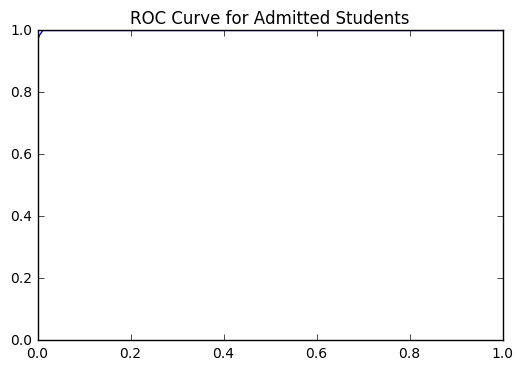

In [47]:
#Generate ROC Curve
ax = plt.subplot(111)
vals = roc_curve(data.admit, predicted)
ax.plot(vals[0], vals[1])

ax.set(title='ROC Curve for Admitted Students', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [48]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [49]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [50]:
combos.head()

,0,1,2,3
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [51]:
# recreate the dummy variables

#keep only what we need for making predictions

combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_prestige2 = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_prestige2.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos= combos[cols_to_keep].join(dummy_prestige2.ix[:,'prestige_2':])

In [52]:
combos.head()

,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4
0,220.0,2.260000,1.0,1.0,0.0,0.0,0.0
1,220.0,2.260000,2.0,1.0,1.0,0.0,0.0
2,220.0,2.260000,3.0,1.0,0.0,1.0,0.0
3,220.0,2.260000,4.0,1.0,0.0,0.0,1.0
4,220.0,2.453333,1.0,1.0,0.0,0.0,0.0


#### 5.2 Make predictions on the enumerated dataset

In [53]:
new_train_cols = combos[['gre','gpa','prestige_2','prestige_3','prestige_4']]

In [32]:
new_train_cols.head()

,gre,gpa,prestige_2,prestige_3,prestige_4
0,220.0,2.260000,0.0,0.0,0.0
1,220.0,2.260000,1.0,0.0,0.0
2,220.0,2.260000,0.0,1.0,0.0
3,220.0,2.260000,0.0,0.0,1.0
4,220.0,2.453333,0.0,0.0,0.0


In [54]:
#Predicting with the new enumerated data sest and adding the predicted prob to the original dataset
new_pred = result.predict_proba(new_train_cols)

combos['pred_admin'] =  new_pred[:,1:]

#### 5.3 Interpret findings for the last 4 observations

In [55]:
combos.tail(4)

,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4,pred_admin
396,800.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0
397,800.0,4.0,2.0,1.0,1.0,0.0,0.0,1.0
398,800.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0
399,800.0,4.0,4.0,1.0,0.0,0.0,1.0,0.0


Answer: The proablity of admittance decresases as the prestige decreases. 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.